## Imports

In [16]:
import numpy as np
import pandas as pd
import gc
import random
random.seed(2018)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import lightgbm as lgb
#import xgboost as xgb

from IPython.display import display # Allows the use of display() for DataFrames

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
#xgb.__version__
#conda install -c conda-forge xgboost 

## Load the data

In [3]:
#import the data
print('loding the data')
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')


loding the data


In [4]:
print("Train rows and columns : ", train_df.shape)
print("Test rows and columns : ", test_df.shape)
train_df.head()

Train rows and columns :  (4459, 4993)
Test rows and columns :  (49342, 4992)


,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


## Preprocessing

In [5]:
X_train = train_df.drop(["ID", "target"], axis=1) #drop columns
y_train = np.log1p(train_df["target"].values) #transform label

X_test = test_df.drop(["ID"], axis=1)

In [6]:
print("Train set size: {}".format(X_train.shape))
print("Test set size: {}".format(X_test.shape))

Train set size: (4459, 4991)
Test set size: (49342, 4991)


## Missing values

In [7]:
missing_df = train_df.isnull().sum(axis=0).reset_index() #gives how many null values are present in each column
#missing_df # reset index attaches a new index column starting with 0
missing_df.columns = ['column_name', 'missing_count'] #naming the columns
#missing_df
missing_df = missing_df[missing_df['missing_count']>0]# printing  missing values 
#missing_df # printing  missing values 
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


## Datatypes

In [8]:
dtype_df = train_df.dtypes.reset_index()
#dtype_df
dtype_df.columns = ["Count", "Column Type"]
#dtype_df
dtype_df.groupby("Column Type").aggregate('count').reset_index() #counting no. of rows in different datatypes 


,Column Type,Count
0,int64,3147
1,float64,1845
2,object,1


## Constant Values

In [9]:
unique_df = train_df.nunique().reset_index() #returns no. of unique elements in each column
unique_df.columns = ["col_name", "unique_count"] #naming the columns

constant_df = unique_df[unique_df["unique_count"]==1] #if column has only 1 value
constant_df.shape #no. of such rows
#constant_df # printing such rows

#str(constant_df.col_name.tolist())

(256, 2)

## Remove Constant Values

In [12]:
### Get the X and y variables for building model ###
train_X = train_df.drop(constant_df.col_name.tolist() + ["ID", "target"], axis=1)
test_X = test_df.drop(constant_df.col_name.tolist() + ["ID"], axis=1)
train_y = np.log1p(train_df["target"].values)

## Model Building

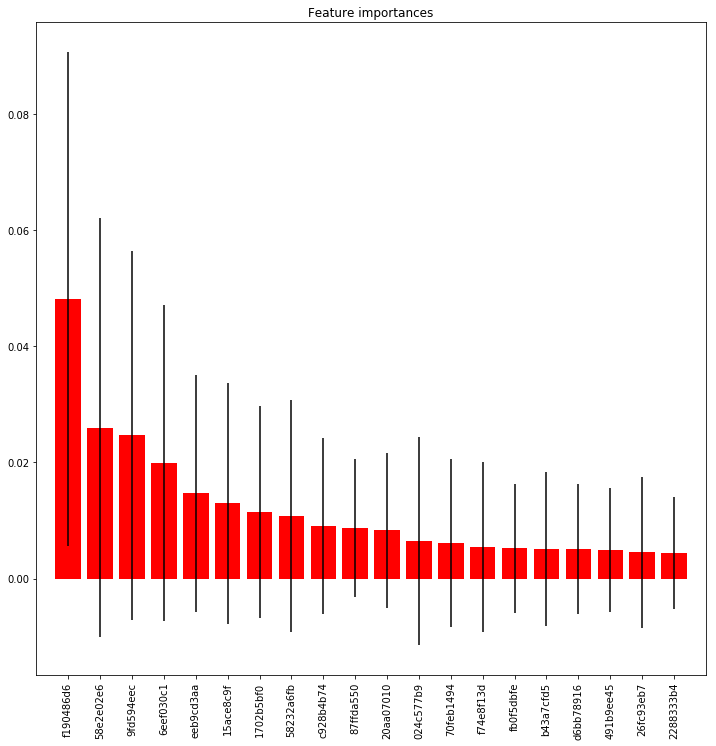

In [13]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

## plot the importances ##
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

## Prediction

In [14]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=200, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [17]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44231
[400]	valid_0's rmse: 1.42178
Early stopping, best iteration is:
[380]	valid_0's rmse: 1.42093
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44249
[400]	valid_0's rmse: 1.40968
[600]	valid_0's rmse: 1.40662
Early stopping, best iteration is:
[532]	valid_0's rmse: 1.40543
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.44369
[400]	valid_0's rmse: 1.41905
Early stopping, best iteration is:
[479]	valid_0's rmse: 1.41808
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.49096
[400]	valid_0's rmse: 1.45485
[600]	valid_0's rmse: 1.44857
[800]	valid_0's rmse: 1.44774
[1000]	valid_0's rmse: 1.44622
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 1.44611
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.48257
[400]	valid_0's rmse:

In [20]:
# Making a submission file #
sub_df = pd.DataFrame({"ID":test_df["ID"].values})
sub_df["target"] = pred_test_full
sub_df.to_csv("baseline_lgb.csv", index=False)

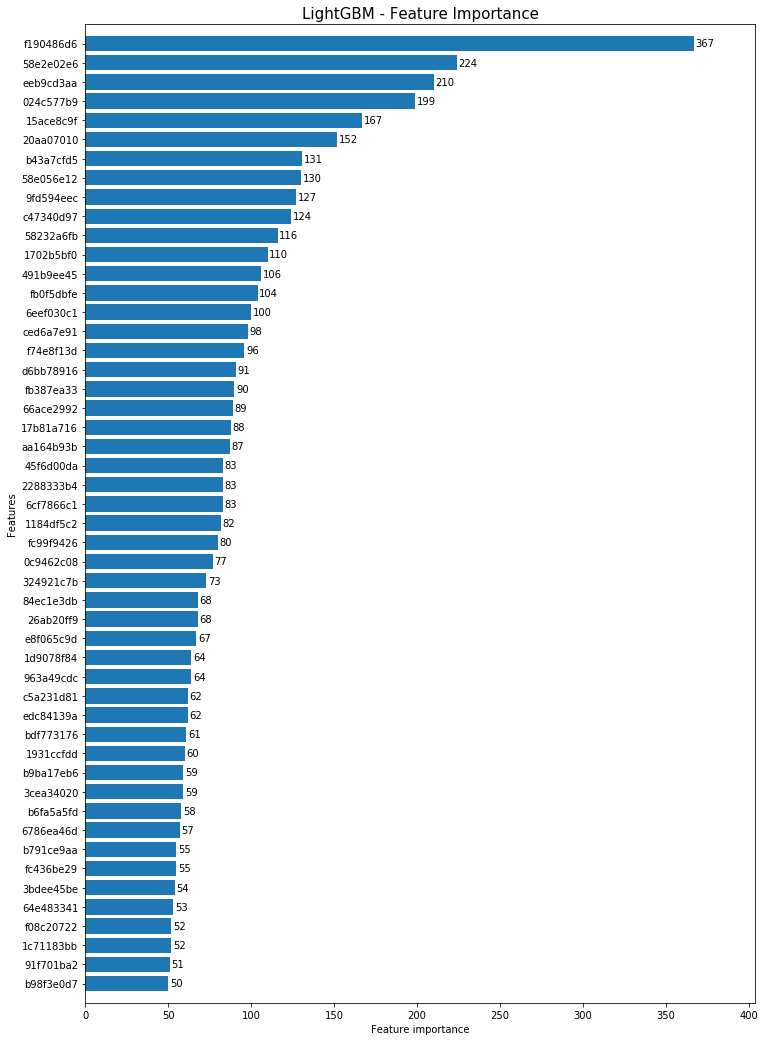

In [21]:
### Feature Importance ###
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

## Remove constant features

In [ ]:
# check and remove constant columns
colsToRemove = []
for col in X_train.columns:
    if X_train[col].std() == 0: #if variace is zero, remove it
        colsToRemove.append(col)
        
# remove constant columns in the training set
X_train.drop(colsToRemove, axis=1, inplace=True)

# remove constant columns in the test set
X_test.drop(colsToRemove, axis=1, inplace=True) 

print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))
print(colsToRemove)

In [ ]:
gc.collect()
print("Train set size: {}".format(X_train.shape))
print("Test set size: {}".format(X_test.shape))

## Remove duplicates

In [ ]:
pd.X_train.drop_duplicates

## Drop sparse data

In [ ]:
def drop_sparse(train, test):
    flist = [x for x in train.columns if not x in ['ID','target']]
    for f in flist:
        if len(np.unique(train[f]))<2:
            train.drop(f, axis=1, inplace=True)
            test.drop(f, axis=1, inplace=True)
    return train, test

In [ ]:
%%time
X_train, X_test = drop_sparse(X_train, X_test)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax=MinMaxScaler()
x_train=minmax.fit_transform(train)
x_test=minmax.transform(test)

In [ ]:
y_train=np.log1p(y_train)


In [ ]:
#train dev split
from sklearn.model_selection import train_test_split

print('train, dev split')
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1) #train 80, dev 20



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import seaborn as sns
RF_clf=RandomForestRegressor(random_state=42,n_jobs=-1)

In [ ]:
RF_clf.fit(X_train,Y_train)

In [ ]:
def evaluate(model, features, labels):
    predictions = model.predict(features)
    errors = abs(predictions - labels)
    m = 100 * np.mean(errors / labels)
    accuracy = 100 - m
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [ ]:
print('valid Accuracy')
valid_accuracy = evaluate(RF_clf, X_valid, Y_valid)